In [1]:
# from the team_hit virtualenv in Python

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import contractions
import collections
import shap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_text import LimeTextExplainer
import timeit
import shap
import eli5


In [3]:
# load the nltk specific parameters
stop_words = nltk.corpus.stopwords.words('english')

## 1. Configure the YES/NO hurricane data 
From the training data for hurricanes Mathew, Irma, Maria, and Harvey

In [4]:
# training data of tweets knowns to relate to hurricanes Mathew, Maria, Irma and Harvey

df_yes = pd.read_csv('./DATA/all_hurricanes_tweets_train.csv')
df_yes['is_hurricane'] = 1
df_yes.shape

(13209, 19)

In [5]:
# tweets selected from the same time periods based on terms not related to hurricanes 

df_no = pd.read_csv('./DATA/mix_2016_2017_not_hurricane.csv')
df_no = df_no.rename({'id': 'tweet_id'}, axis=1)
df_no['is_hurricane'] = 0
df_no.shape

(20610, 17)

In [6]:
# ensure the same number of hurrican tweets and not hurricane tweets
df_no = df_no.sample(n = 13209)
df_no.shape

(13209, 17)

In [7]:
# features from the hurricane dataset

yes_features = set(list(df_yes.columns))
yes_features

{'Unnamed: 0',
 'attachments',
 'author_id',
 'class_label',
 'context_annotations',
 'conversation_id',
 'created_at',
 'edit_history_tweet_ids',
 'entities',
 'in_reply_to_user_id',
 'is_hurricane',
 'lang',
 'possibly_sensitive',
 'public_metrics',
 'referenced_tweets',
 'reply_settings',
 'source',
 'text',
 'tweet_id'}

In [8]:
# features from the not hurricane dataset

no_features = set(list(df_no.columns))
no_features

{'attachments',
 'author_id',
 'conversation_id',
 'created_at',
 'edit_history_tweet_ids',
 'entities',
 'in_reply_to_user_id',
 'is_hurricane',
 'lang',
 'possibly_sensitive',
 'public_metrics',
 'referenced_tweets',
 'reply_settings',
 'source',
 'text',
 'tweet_id',
 'withheld'}

In [9]:
# features unique to either of the two datasets -- retain class_label for category within hurricanes 
# ***** But withhold from training the YES/NO classifier ***** 
print(list(yes_features.union(no_features)))
yes_features.symmetric_difference(no_features)

['edit_history_tweet_ids', 'attachments', 'text', 'referenced_tweets', 'tweet_id', 'author_id', 'lang', 'source', 'withheld', 'is_hurricane', 'class_label', 'Unnamed: 0', 'context_annotations', 'public_metrics', 'in_reply_to_user_id', 'reply_settings', 'created_at', 'conversation_id', 'possibly_sensitive', 'entities']


{'Unnamed: 0', 'class_label', 'context_annotations', 'withheld'}

In [10]:
df = pd.concat([df_yes, df_no])
df.shape

(26418, 20)

In [11]:
retain_features = ['created_at', 'edit_history_tweet_ids', 'author_id', 'source', 'in_reply_to_user_id', 'text', 'conversation_id', 'class_label', 'reply_settings', 'tweet_id', 'entities', 'attachments', 'lang', 'public_metrics', 'referenced_tweets', 'possibly_sensitive', 'is_hurricane']
len(retain_features)

17

In [12]:
df = df[retain_features]
df.shape

(26418, 17)

In [13]:
# X features: remove class_label and is_hurricane from df
X_features = ['created_at', 'edit_history_tweet_ids', 'author_id', 'source', 'in_reply_to_user_id', 'text', 'conversation_id', 'reply_settings', 'tweet_id', 'entities', 'attachments', 'lang', 'public_metrics', 'referenced_tweets', 'possibly_sensitive']
X_ = df[X_features]
X_.shape

(26418, 15)

In [14]:
# y is the label of YES/NO is_hurricane
y = df['is_hurricane']
y.shape

(26418,)

## 2. Preprocess the text

In [15]:
# select or combine lemmatization, stemming, stopword removal to compare performance

def preprocess_text(text, flg_stemm = True, flg_lemm = True, lst_stopwords=None):
    text_clean = re.sub(r'[^\w\s.,]', '', str(text).strip())
    lst_text = text_clean.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if flg_stemm == True:
        stemm = nltk.stem.porter.PorterStemmer()
        lst_text = [stemm.stem(word) for word in lst_text]
    if flg_lemm == True:
        lem=nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    text_clean = ' '.join(filter(None, lst_text))
    text_clean = text_clean.replace(" ,",",").replace(' .', '.')
    text_clean = contractions.fix(text_clean)
    return text_clean

In [16]:
X = X_['text'].apply(lambda x: preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words))
X.shape

(26418,)

## 3. Train-Test split the data

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42, test_size=0.20, shuffle=True)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df = 3)
train_vc = tfidf_vec.fit_transform(X_train)
test_vc = tfidf_vec.transform(X_test)

## 4. Initial performance on default parameters 

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprec

,accuracy,precision,recall,f1-score
Logistic Regression,0.978047,0.978143,0.978099,0.978047
MultinomialNB,0.966124,0.966137,0.966113,0.966122
RandomForest,0.976154,0.976152,0.97617,0.976154
SVM,0.981643,0.981697,0.981684,0.981643
MLP,0.976722,0.976813,0.976773,0.976722


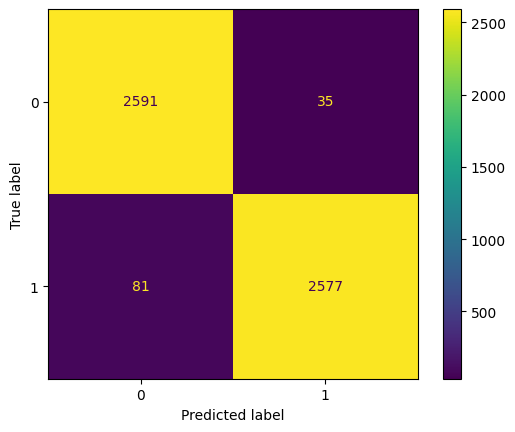

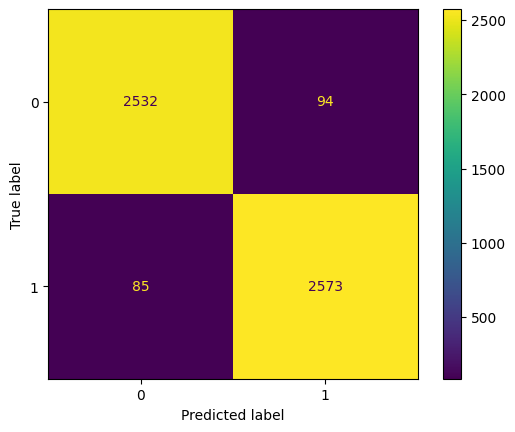

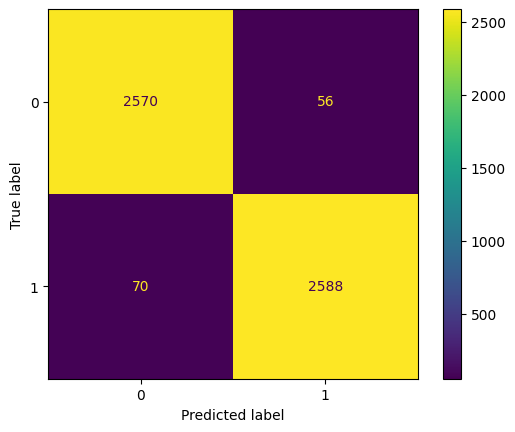

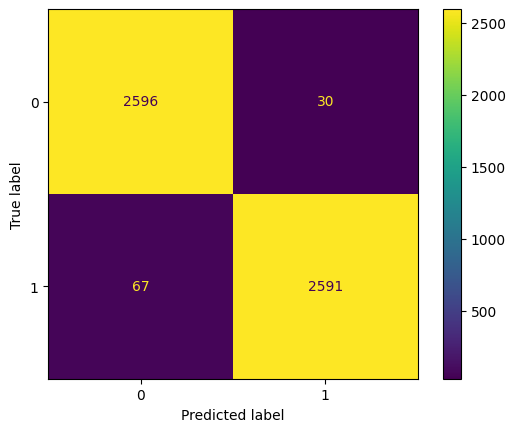

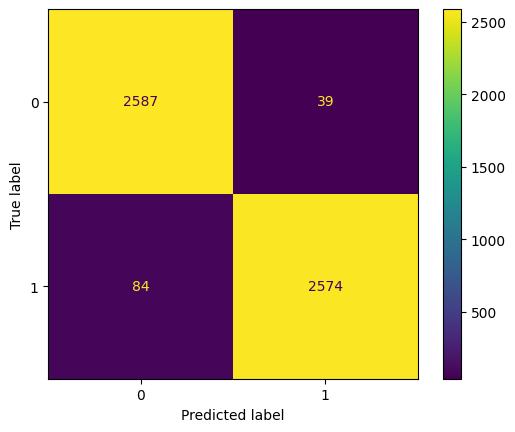

In [18]:
seed = 42
#kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
models = {"Logistic Regression": LogisticRegression(),
          "MultinomialNB": MultinomialNB(),
          "RandomForest": RandomForestClassifier(),
          "SVM": SVC(), #boxed out due to computational cost
          "MLP": MLPClassifier()
          }

results_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])
#results_roc = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

target_names = ['Hurricane Tweet', 'Not Hurricane Tweet']


for name, model in models.items():
    
    #kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    fit = model.fit(train_vc, y_train)
    pred = model.predict(test_vc)
    #yproba = model.predict_proba(test_vc)[::, 1]
    #fpr, tpr, _ = metrics.roc_curve(y_test, yproba)
    #auc = metrics.roc_auc_score(y_test, yproba)
    #results_roc = results_roc.append({'classifiers':model.__class__.__name__, 'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)

    report_dict = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
        
    results_df.loc[name, 'accuracy'] = report_dict['accuracy']
    results_df.loc[name, 'precision'] = report_dict['macro avg']['precision']
    results_df.loc[name, 'recall'] = report_dict['macro avg']['recall']
    results_df.loc[name, 'f1-score'] = report_dict['macro avg']['f1-score']

    metrics.plot_confusion_matrix(fit, test_vc, y_test)

results_df

In [19]:
# try seaborn https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions

# https://seaborn.pydata.org/tutorial/color_palettes.html

## 5. Grid Search to optimize paramters 

### a. Logistic Regression

In [20]:
lr_classifier = LogisticRegression()
lr_parameters = {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10, 100], 'penalty' : ['l2', 'elasticnet'], 'multi_class': ['auto', 'ovr', 'multinomial']}

In [21]:
lr_best = GridSearchCV(lr_classifier, lr_parameters)
lr_best.fit(train_vc, y_train)
lr_best.best_params_
lr_pred = lr_best.predict(test_vc)
metrics.classification_report(y_test, lr_pred, target_names=target_names, output_dict=True)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'Hurricane Tweet': {'precision': 0.974445697106351,
  'recall': 0.9874333587204874,
  'f1-score': 0.9808965386797805,
  'support': 2626},
 'Not Hurricane Tweet': {'precision': 0.9874189858940144,
  'recall': 0.9744168547780286,
  'f1-score': 0.9808748343116834,
  'support': 2658},
 'accuracy': 0.9808856926570779,
 'macro avg': {'precision': 0.9809323415001827,
  'recall': 0.980925106749258,
  'f1-score': 0.980885686495732,
  'support': 5284},
 'weighted avg': {'precision': 0.9809716247364814,
  'recall': 0.9808856926570779,
  'f1-score': 0.9808856207747083,
  'support': 5284}}

In [22]:
# best parameters for logistic regression
best_logistic_regression = lr_best.best_params_

lr_best.best_params_

{'C': 10, 'multi_class': 'auto', 'penalty': 'l2'}

### 5.b. Naive Bayes

In [23]:
nb_classifier = MultinomialNB()
nb_parameters = {'alpha' : [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000], 'fit_prior' : ['True', 'False']}

In [24]:
nb_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)
nb_best.fit(train_vc, y_train)
nb_best.best_params_
nb_pred = nb_best.predict(test_vc)
metrics.classification_report(y_test, nb_pred, target_names=target_names, output_dict=True)


{'Hurricane Tweet': {'precision': 0.9675200611387085,
  'recall': 0.9642041127189642,
  'f1-score': 0.9658592408926188,
  'support': 2626},
 'Not Hurricane Tweet': {'precision': 0.9647544056992876,
  'recall': 0.9680210684725358,
  'f1-score': 0.9663849765258217,
  'support': 2658},
 'accuracy': 0.9661241483724451,
 'macro avg': {'precision': 0.966137233418998,
  'recall': 0.9661125905957499,
  'f1-score': 0.9661221087092202,
  'support': 5284},
 'weighted avg': {'precision': 0.9661288589892041,
  'recall': 0.9661241483724451,
  'f1-score': 0.9661237006414933,
  'support': 5284}}

In [25]:
# best parameters for naive bayes
nb_best.best_params_

{'alpha': 1, 'fit_prior': 'True'}

### 5.c. Random Forest

In [26]:
rf_classifier = RandomForestClassifier()
rf_parameters = {'n_estimators' : ['100', '200', '300'], 'max_depth': [3, 5, 10]}

In [27]:
rf_best = GridSearchCV(nb_classifier, nb_parameters, cv=5)
rf_best.fit(train_vc, y_train)
rf_best.best_params_
rf_pred = nb_best.predict(test_vc)
metrics.classification_report(y_test, rf_pred, target_names=target_names, output_dict=True)

{'Hurricane Tweet': {'precision': 0.9675200611387085,
  'recall': 0.9642041127189642,
  'f1-score': 0.9658592408926188,
  'support': 2626},
 'Not Hurricane Tweet': {'precision': 0.9647544056992876,
  'recall': 0.9680210684725358,
  'f1-score': 0.9663849765258217,
  'support': 2658},
 'accuracy': 0.9661241483724451,
 'macro avg': {'precision': 0.966137233418998,
  'recall': 0.9661125905957499,
  'f1-score': 0.9661221087092202,
  'support': 5284},
 'weighted avg': {'precision': 0.9661288589892041,
  'recall': 0.9661241483724451,
  'f1-score': 0.9661237006414933,
  'support': 5284}}

In [28]:
# best parameters for random forest
rf_best.best_params_

{'alpha': 1, 'fit_prior': 'True'}

### 5.d. Support Vector Machine

In [29]:
svm_classifier = SVC()

In [30]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']} 

In [31]:
svm_best = GridSearchCV(svm_classifier, param_grid, cv=5)

In [32]:
svm_best.fit(train_vc, y_train)
svm_best.best_params_
svm_pred = svm_best.predict(test_vc)
metrics.classification_report(y_test, svm_pred, target_names=target_names, output_dict=True)

KeyboardInterrupt: 

In [ ]:
svm_best.best_params_

## 5.e Multi-layer Perceptron

In [33]:
MLPClassifier = MLPClassifier()
mlp_parameters = {'hidden_layer_sizes' : [10, 50, 100, 200], 'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'alpha' : ['0.0001', '0.001', '0.01', '0.1']}

In [ ]:
mlp_best = GridSearchCV(MLPClassifier, mlp_parameters, cv=5)

In [34]:
mlp_best.fit(train_vc, y_train)
mlp_best.best_params_
mlp_pred = mlp_best.predict(test_vc)
metrics.classification_report(y_test, mlp_pred, target_names=target_names, output_dict=True)

ValueError: 
All the 320 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cameron/Documents/MADS/699/DisasterTweets/MODELS/ENVIRONMENT/working_specs/team_hit/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cameron/Documents/MADS/699/DisasterTweets/MODELS/ENVIRONMENT/working_specs/team_hit/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 762, in fit
    return self._fit(X, y, incremental=False)
  File "/home/cameron/Documents/MADS/699/DisasterTweets/MODELS/ENVIRONMENT/working_specs/team_hit/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 385, in _fit
    self._validate_hyperparameters()
  File "/home/cameron/Documents/MADS/699/DisasterTweets/MODELS/ENVIRONMENT/working_specs/team_hit/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 464, in _validate_hyperparameters
    if self.alpha < 0.0:
TypeError: '<' not supported between instances of 'str' and 'float'


In [ ]:
mlp_best.best_params_

In [ ]:
# test optimized classifiers

models = {"Logistic Regression": LogisticRegression(C=100, multi_class='multinomial', penalty='l2'),
          "MultinomialNB": MultinomialNB(fit_prior=False, alpha=5),
          "RandomForest": RandomForestClassifier(n_estimators=200, max_depth = None),
          "SVC": SVC(kernel='poly', degree=2, C=10),
          "MLP": MLPClassifier(hidden_layer_sizes=200, activation='tanh', solver='adam', alpha=0.001)
          }

#fit classifiers and make predictions

for name, model in models.items(): 
    model.fit(train_vc, y_train) 
    pred=model.predict(test_vc)
    test_score = model.score(test_vc, y_test)
    met = metrics.classification_report(y_test, pred, target_names=target_names, output_dict=True)
    confusion_matrix=metrics.confusion_matrix(y_test, pred)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print("{} report: {}".format(name, met))
    print("{} Confusion_matrix: {}".format(name, confusion_matrix))
    print("_"*50)